In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow_datasets as tfds
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

Training dataset: 5994
Test dataset: 5794


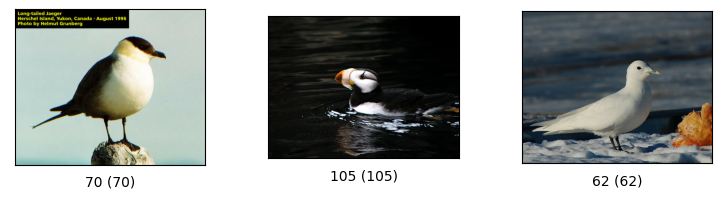

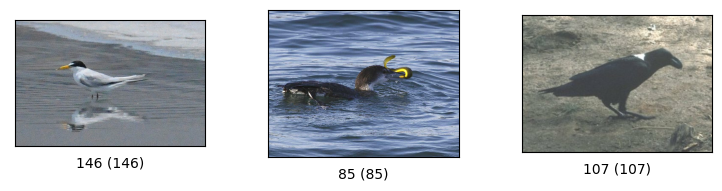

In [2]:
# Settings
batch_size = 4
img_width = 320
img_height = 320

# Fetch dataset
(train_ds_original, test_ds_original), ds_info = tfds.load(
    'caltech_birds2011', 
    split=['train', 'test'], 
    as_supervised=True, 
    shuffle_files=True, 
    with_info=True,
)

# Display dataset
print("Training dataset: {0}".format(len(train_ds_original)))
print("Test dataset: {0}".format(len(test_ds_original)))

fig = tfds.show_examples(train_ds_original.take(3), ds_info, image_key='image')
fig = tfds.show_examples(test_ds_original.take(3), ds_info, image_key='image')

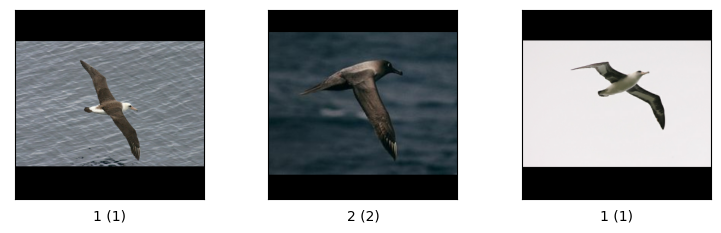

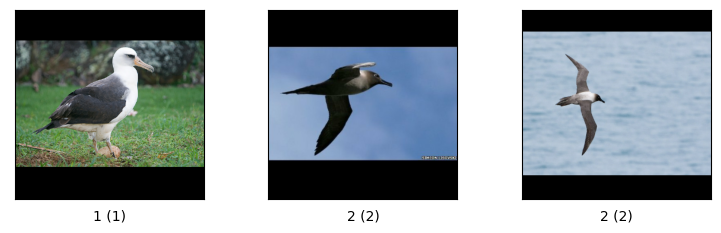

In [3]:
# Prepear dataset
def modify_images(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    image = tf.image.resize_with_pad(
        image,
        img_height, img_width,
        method='bilinear',
        antialias=False,
    )
    
    return image, label


# num_classes = ds_info.features['label'].num_classes
num_classes = 2

filter_labels = lambda image, label: label == 1 or label == 2

train_ds = (
    train_ds_original
    .filter(filter_labels)
    .map(modify_images, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_ds = (
    test_ds_original
    .filter(filter_labels)
    .map(modify_images, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Display dataset
fig = tfds.show_examples(train_ds.take(3), ds_info, image_key='image')
fig = tfds.show_examples(test_ds.take(3), ds_info, image_key='image')

# Batch dataset
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [4]:
from tensorflow import keras
from keras import layers

# Setup model
model = keras.Sequential([
    # Input
    layers.InputLayer(input_shape=(img_height, img_width, 3)),

    # Data augmentation
    layers.RandomContrast(factor=0.1),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.1),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    
    # Normalazation
    layers.Rescaling(scale=1./255),

    # Block 1
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block 2
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block 3
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    # Head
    layers.BatchNormalization(),
    layers.Flatten(),
    
#     layers.Dense(128, activation='relu'),
#     layers.Dense(num_classes),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

# Summarize model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast (RandomCont  (None, 320, 320, 3)      0         
 rast)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 320, 320, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 320, 320, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 320, 320, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 320, 320, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 320, 320, 3)      1

In [5]:
# Prepear model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy'],
    
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

# Train model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=8,
)

# Save model
model.save("output/m2")

Epoch 1/8
15/15 [==============================] - 7s 115ms/step - loss: -61.2227 - binary_accuracy: 0.4667 - val_loss: -61.4247 - val_binary_accuracy: 0.3333
Epoch 2/8
15/15 [==============================] - 1s 50ms/step - loss: -396.9835 - binary_accuracy: 0.5000 - val_loss: -173.8521 - val_binary_accuracy: 0.3333
Epoch 3/8
15/15 [==============================] - 1s 49ms/step - loss: -947.2732 - binary_accuracy: 0.4833 - val_loss: -401.9900 - val_binary_accuracy: 0.3333
Epoch 4/8
15/15 [==============================] - 1s 52ms/step - loss: -1878.8683 - binary_accuracy: 0.5000 - val_loss: -832.4421 - val_binary_accuracy: 0.3333
Epoch 5/8
15/15 [==============================] - 1s 49ms/step - loss: -3057.5396 - binary_accuracy: 0.5000 - val_loss: -1557.3597 - val_binary_accuracy: 0.3333
Epoch 6/8
15/15 [==============================] - 1s 50ms/step - loss: -4335.4941 - binary_accuracy: 0.5000 - val_loss: -2600.2681 - val_binary_accuracy: 0.3333
Epoch 7/8
15/15 [===================

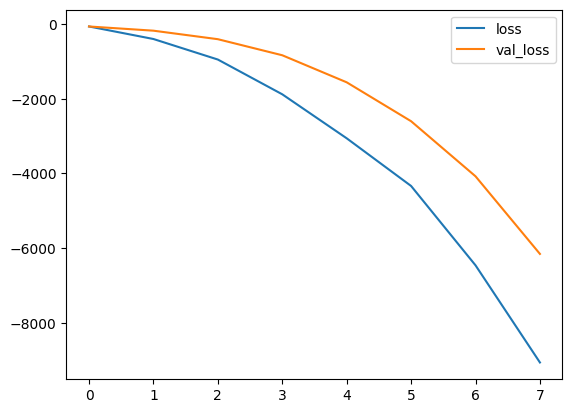

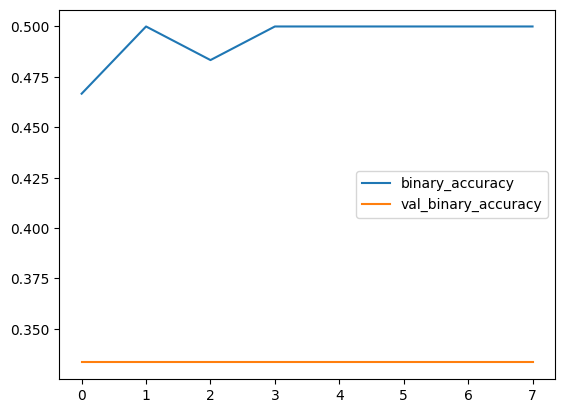

In [6]:
# Plot learning curves
import pandas as pd

history_frame = pd.DataFrame(history.history)

# history_frame.loc[:, ['loss', 'val_loss']].plot()
# history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();